#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET), in GSC. Applied only to linear layers

Search through different percentage

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

In [3]:
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({"axes.grid": True, "grid.linewidth": 0.5})

## Load and check data

In [4]:
exps = ['improved_mag_gsc_searchperc2']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [5]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,model,momentum,network,on_perc,optim_alg,pruning_early_stop,test_noise,use_kwinners,weight_decay,weight_prune_perc
0,"0_model=DSNNWeightedMag,weight_prune_perc=0.0",0.852798,98,0.269407,0,0.834196,0.850845,0.912618,96,0.405564,...,DSNNWeightedMag,0,GSCHeb,0.04,SGD,2,False,True,0.01,0.00
1,"1_model=DSNNMixedHeb,weight_prune_perc=0.0",0.847818,98,0.281906,0,0.830412,0.845230,0.905564,84,0.388323,...,DSNNMixedHeb,0,GSCHeb,0.04,SGD,2,False,True,0.01,0.00
2,"2_model=DSNNWeightedMag,weight_prune_perc=0.05",0.890099,95,0.296016,0,0.874890,0.889610,0.927900,88,0.483934,...,DSNNWeightedMag,0,GSCHeb,0.04,SGD,2,False,True,0.01,0.05
3,"3_model=DSNNMixedHeb,weight_prune_perc=0.05",0.888097,96,0.298604,0,0.872766,0.887267,0.932210,88,0.471395,...,DSNNMixedHeb,0,GSCHeb,0.04,SGD,2,False,True,0.01,0.05
4,"4_model=DSNNWeightedMag,weight_prune_perc=0.1",0.878772,95,0.273460,0,0.863807,0.872913,0.930251,90,0.432210,...,DSNNWeightedMag,0,GSCHeb,0.04,SGD,2,False,True,0.01,0.10


In [6]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)

In [7]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_size_test', 'batch_size_train', 'data_dir', 'dataset_name',
       'debug_sparse', 'debug_weights', 'device', 'hebbian_grow',
       'hebbian_prune_perc', 'learning_rate', 'lr_gamma', 'lr_milestones',
       'lr_scheduler', 'model', 'momentum', 'network', 'on_perc', 'optim_alg',
       'pruning_early_stop', 'test_noise', 'use_kwinners', 'weight_decay',
       'weight_prune_perc'],
      dtype='object')

In [8]:
df.shape

(160, 41)

In [9]:
df.iloc[1]

Experiment Name                1_model=DSNNMixedHeb,weight_prune_perc=0.0
train_acc_max                                                    0.847818
train_acc_max_epoch                                                    98
train_acc_min                                                    0.281906
train_acc_min_epoch                                                     0
train_acc_median                                                 0.830412
train_acc_last                                                    0.84523
val_acc_max                                                      0.905564
val_acc_max_epoch                                                      84
val_acc_min                                                      0.388323
val_acc_min_epoch                                                       0
val_acc_median                                                   0.878723
val_acc_last                                                     0.891066
val_acc_all             0     0.388323

In [10]:
df.groupby('model')['model'].count()

model
DSNNMixedHeb       80
DSNNWeightedMag    80
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [11]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

8

In [12]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(152, 41)

In [13]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

152    6
153    4
154    3
155    1
156    2
157    2
158    1
159    1
Name: epochs, dtype: int64

In [14]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [15]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   38       0.400  0.936  0.850  0.114    76
DSNNWeightedMag                63       0.405  0.933  0.878  0.101    76

In [16]:
agg(['weight_prune_perc'])

val_acc_max_epoch val_acc_max                      model
                         round_mean         min    max   mean    std count
weight_prune_perc                                                         
0.00                             82       0.899  0.913  0.908  0.005     8
0.05                             76       0.920  0.932  0.928  0.004     8
0.10                             81       0.917  0.930  0.926  0.004     8
0.15                             78       0.920  0.936  0.929  0.005     8
0.20                             72       0.915  0.935  0.926  0.007     8
0.25                             85       0.912  0.929  0.924  0.006     8
0.30                             70       0.905  0.932  0.919  0.008     8
0.35                             62       0.909  0.927  0.918  0.007     8
0.40                             53       0.899  0.929  0.911  0.011     8
0.45                             53       0.888  0.931  0.905  0.017     8
0.50                             45       0.874  0.923  0.902  0.020     8
0.55                             53       0.861  0.922  0.895  0.024     8
0.60                             49       0.860  0.915  0.893  0.023     8
0.65                             50       0.839  0.913  0.879  0.031     6
0.70                             39       0.802  0.896  0.863  0.035     6
0.75                             18       0.784  0.883  0.839  0.044     6
0.80                             14       0.756  0.862  0.810  0.042     6
0.85                              9       0.743  0.828  0.790  0.040     6
0.90                              3       0.642  0.774  0.729  0.049     6
0.95                              1       0.652  0.761  0.692  0.047     6
1.00                              0       0.400  0.498  0.444  0.047     6

**Results not in line with what the previous experiment shows - what changed?**
- All hyperparameters are set to the same values - expected similar results
- Any relevant changes to the code?

Edit: yes, momentum is set to 0.9, while in the original experiments is set to 0

In [17]:
agg(['on_perc', 'model'])

val_acc_max_epoch val_acc_max                       \
                               round_mean         min    max   mean    std   
on_perc model                                                                
0.04    DSNNMixedHeb                   38       0.400  0.936  0.850  0.114   
        DSNNWeightedMag                63       0.405  0.933  0.878  0.101   

                        model  
                        count  
on_perc model                  
0.04    DSNNMixedHeb       76  
        DSNNWeightedMag    76

In [46]:
# translate model names
rcParams['figure.figsize'] = 16, 8
d = {
    'DSNNWeightedMag': 'Dynamic Sparse Neural Network (DSNN)',
    'DSNNMixedHeb': 'Sparse Evolutionary Training (SET)',
    'SparseModel': 'Static',        
}
df_plot = df.copy()
df_plot['model'] = df_plot['model'].apply(lambda x: d[x])

In [47]:
def plot_for_paper():
    rcParams['figure.figsize'] = 10,6
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14)
    plt.rcParams.update({'axes.labelsize': 14})
    plt.rcParams.update({'legend.fontsize': 14, 'legend.loc': 'lower left'})
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({"axes.grid": True, "grid.linewidth": 0.5})
    # plt.rcParams.update({})
plot_for_paper()

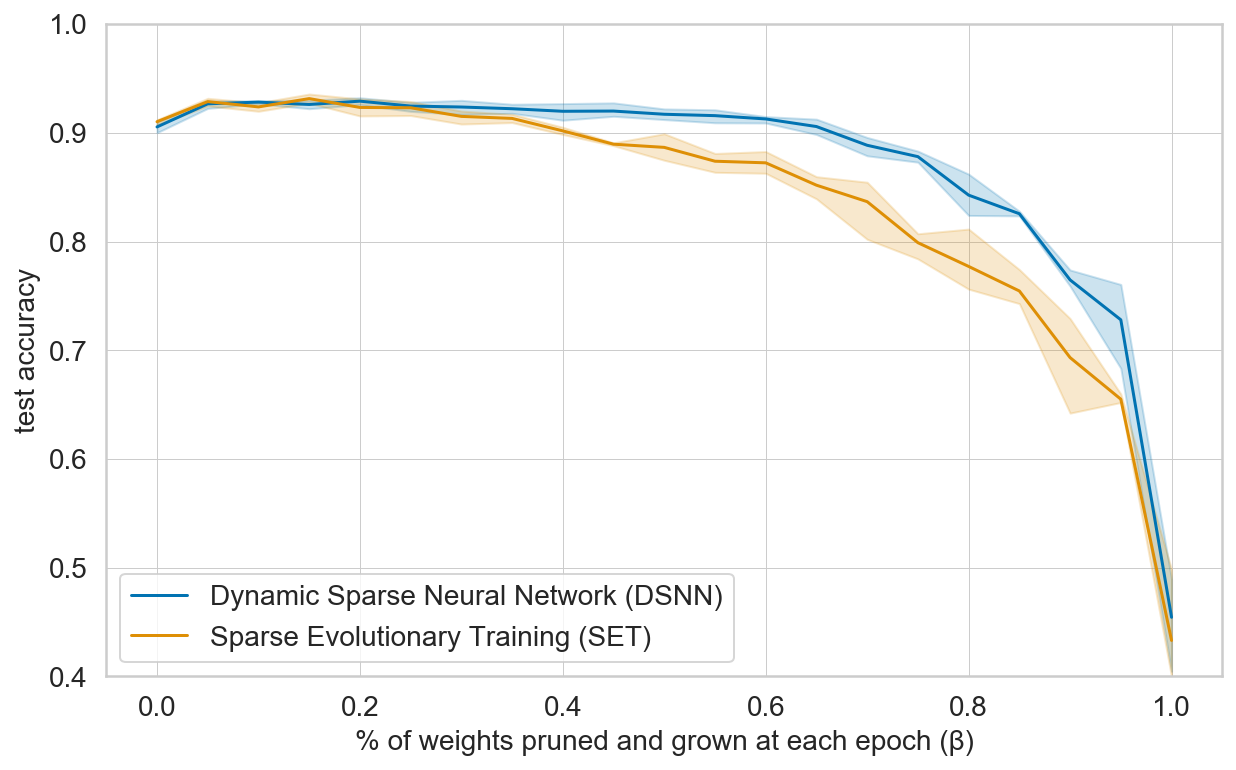

In [50]:
# sns.scatterplot(data=df_plot, x='weight_prune_perc', y='val_acc_max', hue='model')
fig, ax = plt.subplots()
sns.lineplot(data=df_plot, x='weight_prune_perc', y='val_acc_max', hue='model')
plt.xlabel("% of weights pruned and grown at each epoch (β)")
plt.ylabel("test accuracy")
plt.ylim((0.4,1.0))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig('pruning_percentage.png', dpi=300, bbox_inches='tight')

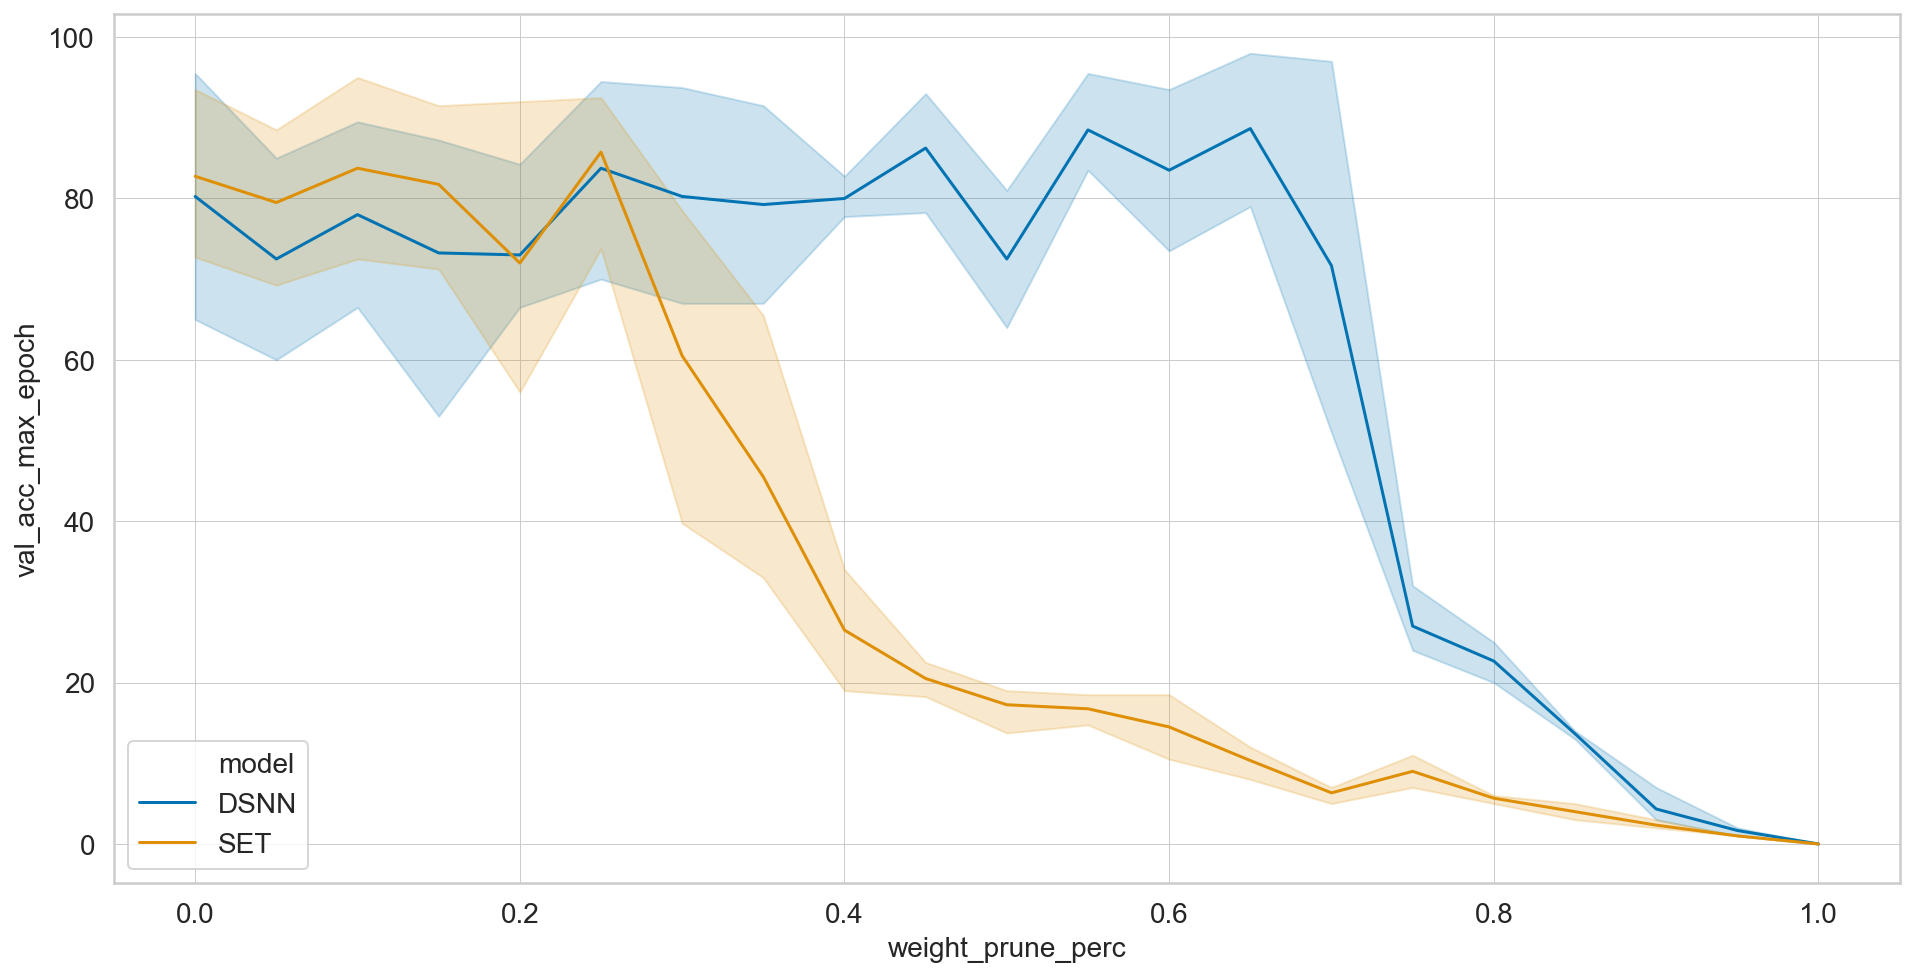

In [21]:
rcParams['figure.figsize'] = 16, 8
filter = df_plot['model'] != 'Static'
sns.lineplot(data=df_plot[filter], x='weight_prune_perc', y='val_acc_max_epoch', hue='model')

Acc where it reaches the max validation accuracy Consistently decreases in the Weight Magnitude - even in cases where the final acc is higher, as in between [0,0.2] of weight_prune_perc

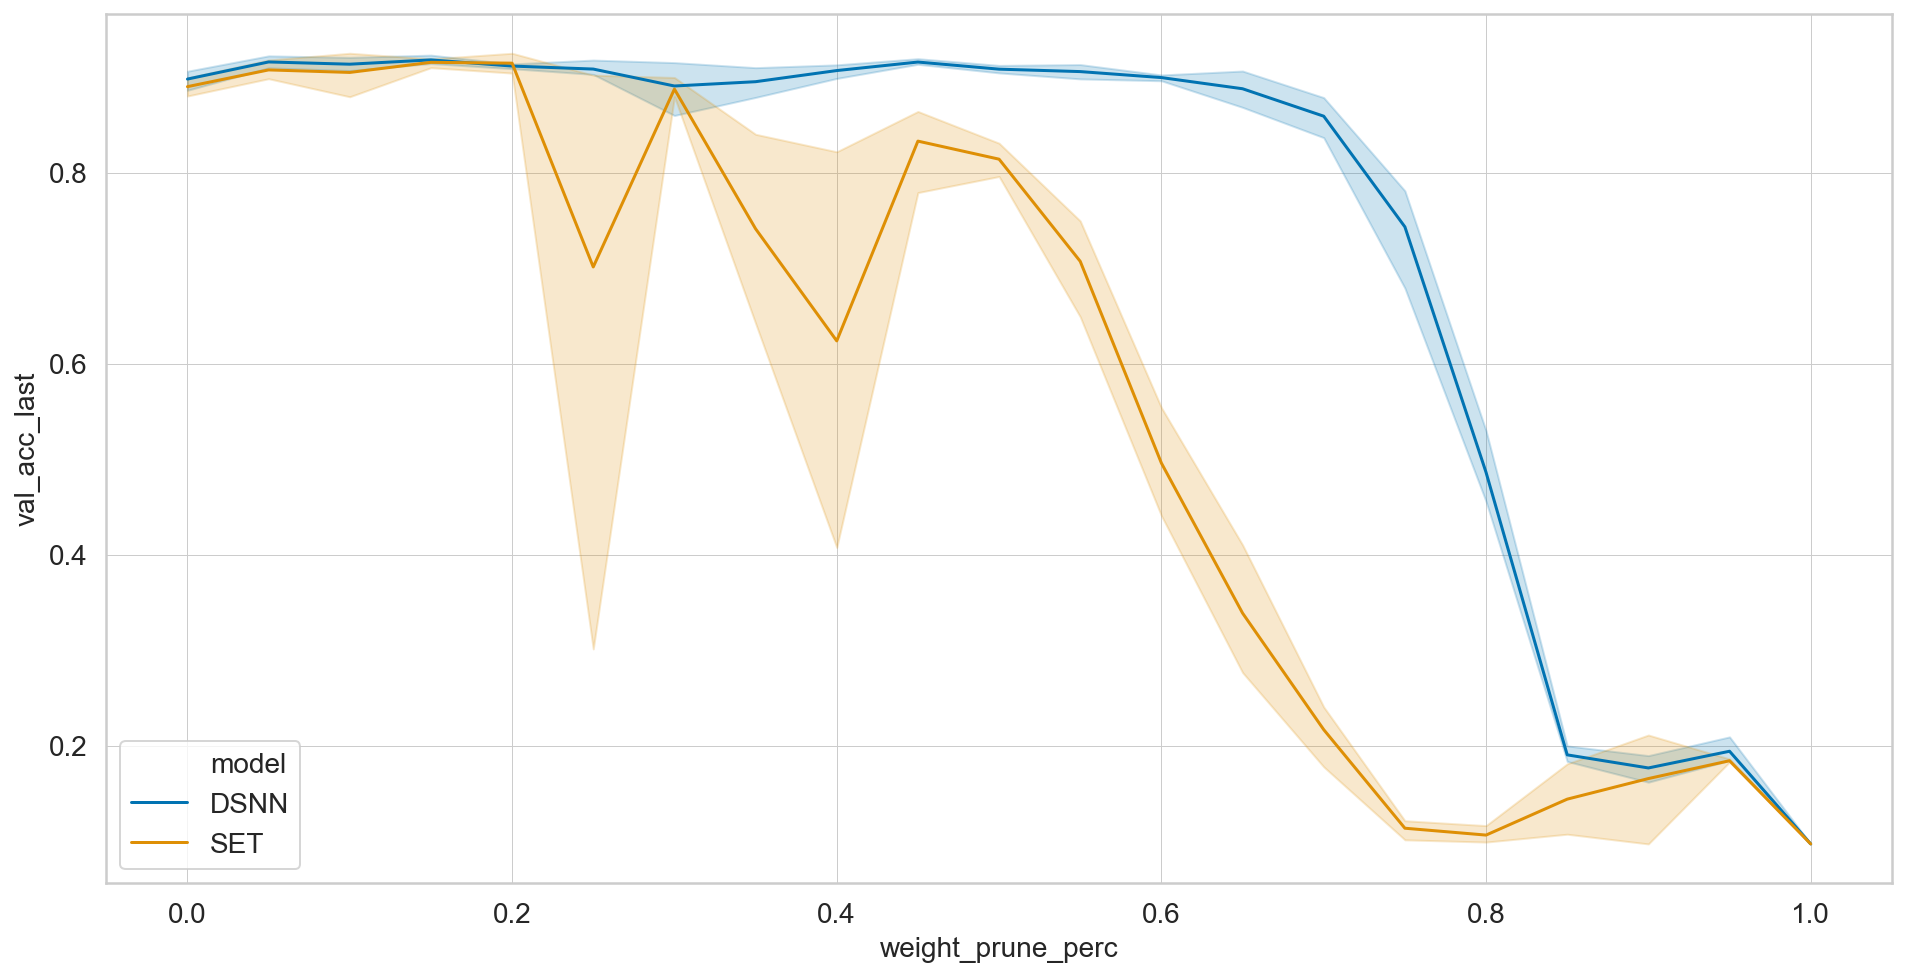

In [22]:
sns.lineplot(data=df_plot, x='weight_prune_perc', y='val_acc_last', hue='model')